# Introducing Pandas

Requirements:

```
(venv) $ pip install pandas matplotlib
```

In [1]:
import pandas as pd
pd.options.display.max_rows = 20

## Introducing `DataFrame`

From the [Pandas docs](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe):

> `DataFrame` is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table. It is generally the most commonly used pandas object.

There are many ways to get a `DataFrame`, but we'll start with a list of dictionaries.

In [2]:
df = pd.DataFrame([
    {'integer': 1, 'float': 1.0, 'string': 'one'},
    {'integer': 2, 'float': 2.0, 'string': 'two'},
    {'integer': 2, 'float': 2.0, 'string': 'two'},
    {'integer': 3, 'float': 3.0, 'string': 'three'},
])

# Print some details about the DataFrame
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
float      4 non-null float64
integer    4 non-null int64
string     4 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 176.0+ bytes


,float,integer,string
0,1.0,1,one
1,2.0,2,two
2,2.0,2,two
3,3.0,3,three


The Jupyter Notebook automatically renders `DataFrame` as HTML!

Note the first column; this is an `Index`, and is an essential component of `DataFrame`. Here, it was auto-generated, but we can also set it:

In [3]:
df_index = df.set_index('string')
df_index

,float,integer
string,,
one,1.0,1
two,2.0,2
two,2.0,2
three,3.0,3


The `Index` plays a key role in slicing the `DataFrame`:

In [4]:
# Slice by label
df_index.loc['two']

,float,integer
string,,
two,2.0,2
two,2.0,2


In [5]:
# Slice by position
df_index.iloc[-2:]

,float,integer
string,,
two,2.0,2
three,3.0,3


We can also get individual columns:

In [6]:
floats = df_index['float']
floats

string
one      1.0
two      2.0
two      2.0
three    3.0
Name: float, dtype: float64

This is a `Series`, which is essentially a one-dimensional `DataFrame`, with a defined data type. Put another way, a `DataFrame` is a collection of `Series`.

Note that the `Series` retained the `Index` of our `DataFrame`, so we can use similar slicing:

In [7]:
floats['two']

two    2.0
two    2.0
Name: float, dtype: float64

`Series` and `DataFrame` support element-wise operations:

In [8]:
df_index['float'] * df_index['integer']

string
one      1.0
two      4.0
two      4.0
three    9.0
dtype: float64

In [9]:
df_index * df_index

,float,integer
string,,
one,1.0,1
two,4.0,4
two,4.0,4
three,9.0,9


In [10]:
number_format = 'Number {}'.format
df_index['integer'].apply(number_format)

string
one      Number 1
two      Number 2
two      Number 2
three    Number 3
Name: integer, dtype: object

In [11]:
df_index.applymap(number_format)

,float,integer
string,,
one,Number 1.0,Number 1
two,Number 2.0,Number 2
two,Number 2.0,Number 2
three,Number 3.0,Number 3


## Using `DataFrame` with Django

Django gives us a handy way to build a list of dictionaries:

In [12]:
gig_values = Gig.objects.past().published().values('date', 'venue__name', 'venue__city')
gig_values[:5]

[{'date': datetime.date(2017, 3, 11), 'venue__name': 'Secret Venue', 'venue__city': 'Somerville, MA'}, {'date': datetime.date(2016, 12, 16), 'venue__name': 'Great Scott', 'venue__city': 'Allston, MA'}, {'date': datetime.date(2016, 9, 25), 'venue__name': 'Brighton Music Hall', 'venue__city': 'Allston, MA'}, {'date': datetime.date(2016, 9, 10), 'venue__name': 'Pinebanks Field', 'venue__city': 'Jamaica Plain, MA'}, {'date': datetime.date(2016, 8, 7), 'venue__name': 'State Park', 'venue__city': 'Cambridge, MA'}]

`DataFrame` doesn't know what to do with a `QuerySet`; it wants something that looks more like a list.  
We could use `list(gig_values)`, but `gig_values.iterator()` is more efficient.

In [13]:
gigs = pd.DataFrame(gig_values.iterator())
gigs.info()
gigs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 3 columns):
date           269 non-null object
venue__city    269 non-null object
venue__name    269 non-null object
dtypes: object(3)
memory usage: 6.4+ KB


,date,venue__city,venue__name
0,2017-03-11,"Somerville, MA",Secret Venue
1,2016-12-16,"Allston, MA",Great Scott
2,2016-09-25,"Allston, MA",Brighton Music Hall
3,2016-09-10,"Jamaica Plain, MA",Pinebanks Field
4,2016-08-07,"Cambridge, MA",State Park
5,2016-08-06,"Manchester, NH",Fuzz Hut
6,2016-08-05,"Stockbridge, MA",Chesterfest
7,2016-07-30,"Providence, RI",Dusk
8,2016-07-29,"New York, NY",Cake Shop
9,2016-07-28,"Baltimore, MD",Club 603


This is a good place to start, and we've already got the answer to "How many gigs have we played"?

However, there are a few ways we can make this easier to work with:

- Shorter column names
- Predictable column order
- Indexed and sorted by date

For more control, we'll use a list of tuples to initialize the DataFrame.

In [14]:
gig_values = Gig.objects.past().published().values_list('date', 'venue__name', 'venue__city')
gig_values[:5]

[(datetime.date(2017, 3, 11), 'Secret Venue', 'Somerville, MA'), (datetime.date(2016, 12, 16), 'Great Scott', 'Allston, MA'), (datetime.date(2016, 9, 25), 'Brighton Music Hall', 'Allston, MA'), (datetime.date(2016, 9, 10), 'Pinebanks Field', 'Jamaica Plain, MA'), (datetime.date(2016, 8, 7), 'State Park', 'Cambridge, MA')]

In [15]:
gigs = pd.DataFrame(gig_values.iterator(), columns=['date', 'venue', 'city'])

gigs['date'] = pd.to_datetime(gigs['date'])
gigs = gigs.set_index('date').sort_index()

gigs.info()
gigs.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 269 entries, 2005-11-20 to 2017-03-11
Data columns (total 2 columns):
venue    269 non-null object
city     269 non-null object
dtypes: object(2)
memory usage: 6.3+ KB


,venue,city
date,,
2005-11-20,Great Scott,"Allston, MA"
2005-12-18,TT The Bear's Place,"Cambridge, MA"
2006-01-07,Sin-E,"New York, NY"
2006-02-01,TT The Bear's Place,"Cambridge, MA"
2006-02-16,Great Scott,"Allston, MA"


## Answering questions


### What gigs  did we play last year?

In [16]:
gigs.loc['2016']

,venue,city
date,,
2016-01-31,Great Scott,"Allston, MA"
2016-03-12,The Bowery Electric,"New York, NY"
2016-05-12,Great Scott,"Allston, MA"
2016-05-14,C'Mon Everybody,"Brooklyn, NY"
2016-07-08,The Sinclair,"Cambridge, MA"
2016-07-09,Grumpy's,"Falmouth, MA"
2016-07-27,Black Cat,"Washington, DC"
2016-07-28,Club 603,"Baltimore, MD"
2016-07-29,Cake Shop,"New York, NY"


### How many gigs have we played each year?

In [17]:
years = gigs.resample('A').size().to_period()
years

date
2005     2
2006    17
2007    41
2008    40
2009    50
2010    20
2011     8
2012    25
2013    15
2014    21
2015    13
2016    16
2017     1
Freq: A-DEC, dtype: int64

In [18]:
%matplotlib inline

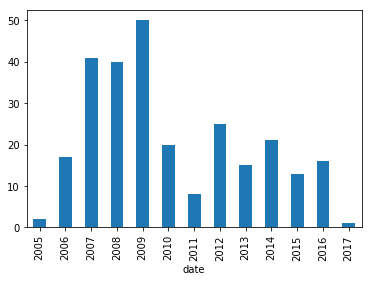

In [19]:
years.plot.bar()

### What are our most active months?

In [20]:
months = gigs.reset_index()['date'].dt.strftime('%m %b').value_counts()
months

03 Mar    41
10 Oct    37
06 Jun    32
11 Nov    31
07 Jul    29
05 May    23
09 Sep    22
02 Feb    15
08 Aug    12
12 Dec    10
04 Apr     9
01 Jan     8
Name: date, dtype: int64

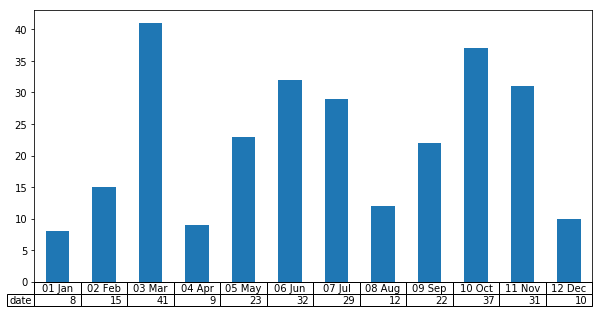

In [21]:
ax = months.sort_index().plot.bar(table=True, figsize=(10,5))
ax.get_xaxis().set_visible(False)

### What cities have we played?

In [22]:
gigs['city']

date
2005-11-20          Allston, MA
2005-12-18        Cambridge, MA
2006-01-07         New York, NY
2006-02-01        Cambridge, MA
2006-02-16          Allston, MA
2006-03-05         New York, NY
2006-03-07        Cambridge, MA
2006-03-25           Boston, MA
2006-05-25        Cambridge, MA
2006-06-20        Cambridge, MA
                    ...        
2016-07-28        Baltimore, MD
2016-07-29         New York, NY
2016-07-30       Providence, RI
2016-08-05      Stockbridge, MA
2016-08-06       Manchester, NH
2016-08-07        Cambridge, MA
2016-09-10    Jamaica Plain, MA
2016-09-25          Allston, MA
2016-12-16          Allston, MA
2017-03-11       Somerville, MA
Name: city, dtype: object

In [23]:
cities = gigs['city'].value_counts()
cities

Cambridge, MA         50
Allston, MA           30
New York, NY          20
Brooklyn, NY          12
Boston, MA             9
Somerville, MA         7
Jamaica Plain, MA      6
Chicago, IL            6
Buffalo, NY            5
Pittsburgh, PA         5
                      ..
Providence, RI         1
Lafayette, IN          1
Iowa City, IA          1
Waltham, MA            1
Falmouth, MA           1
Manchester, NH         1
Yspsilanti, MI         1
Fredericksburg, VA     1
Dekalb, IL             1
Collegeville, PA       1
Name: city, dtype: int64

In [24]:
cities.describe()

count    86.000000
mean      3.127907
std       6.511161
min       1.000000
25%       1.000000
50%       1.000000
75%       2.750000
max      50.000000
Name: city, dtype: float64

In [25]:
top_cities = cities[cities > cities.mean()]
top_cities

Cambridge, MA        50
Allston, MA          30
New York, NY         20
Brooklyn, NY         12
Boston, MA            9
Somerville, MA        7
Jamaica Plain, MA     6
Chicago, IL           6
Buffalo, NY           5
Pittsburgh, PA        5
Philadelphia, PA      4
Los Angeles, CA       4
Austin, TX            4
Cleveland, OH         4
Northampton, MA       4
Name: city, dtype: int64

When did we play in Pittsburgh?

In [26]:
in_pgh = gigs['city'].str.contains('Pittsburgh')
gigs[in_pgh]

,venue,city
date,,
2007-06-30,Bloomfield Bridge Tavern,"Pittsburgh, PA"
2008-03-02,Garfield Art Works,"Pittsburgh, PA"
2009-10-19,Thunderbird Cafe,"Pittsburgh, PA"
2010-10-17,Garfield Art Works,"Pittsburgh, PA"
2012-06-22,Garfield Art Works,"Pittsburgh, PA"


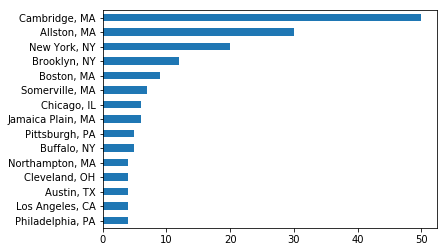

In [27]:
# Adding the ; suppresses `<matplotlib.axes._subplots.AxesSubplot ...>`
top_cities.sort_values().plot.barh();

### What states have we played?

In [28]:
states = gigs['city'].str.split(',').str.get(1).value_counts()
states

 MA    117
 NY     40
 OH     11
 PA     11
 CA     10
 IL      8
 CT      7
 TX      6
 VA      6
 NC      4
      ... 
 ON      2
 UT      1
 MO      1
 CO      1
 WA      1
 RI      1
 VT      1
 LA      1
 QC      1
 KS      1
Name: city, dtype: int64

In [29]:
states.describe()

count     34.000000
mean       7.911765
std       20.467813
min        1.000000
25%        1.250000
50%        3.000000
75%        5.500000
max      117.000000
Name: city, dtype: float64

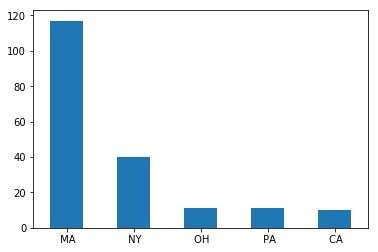

In [30]:
states[:5].plot.bar(rot=0);

### What venues have we played?

In [31]:
venues = gigs.groupby(['venue', 'city']).size()
venues

venue                        city              
3rd Floor Studio             Fredericksburg, VA    1
501 Club                     Minneapolis, MN       1
Allandale Farm               Jamaica Plain, MA     1
Allston Village Street Fair  Allston, MA           1
Arlene's Grocery             New York, NY          1
ArtBeat                      Somerville, MA        1
Atwood's Tavern              Cambridge, MA         1
Bayside Bowl                 Portland, ME          1
Beat Kitchen                 Chicago, IL           1
Berbati's Pan                Portland, OR          1
                                                  ..
Union Hall                   Brooklyn, NY          2
Union Pool                   Brooklyn, NY          1
Ursinus College              Collegeville, PA      1
Valentine's                  Albany, NY            2
Vaudeville Mews              Des Moines, IA        1
Viper Room                   Los Angeles, CA       1
WMBR 88.1 FM Pipeline        Cambridge, MA         

This `Series` has a `MultiIndex`. Very powerful, but beyond the scope of this talk...

In [32]:
venues.describe()

count    171.000000
mean       1.573099
std        2.169083
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       25.000000
dtype: float64

In [33]:
top_venues = venues.nlargest(10)
top_venues

venue                       city          
Great Scott                 Allston, MA       25
TT The Bear's Place         Cambridge, MA     11
The Middle East Upstairs    Cambridge, MA      8
The Middle East Downstairs  Cambridge, MA      7
The Mercury Lounge          New York, NY       5
The Sinclair                Cambridge, MA      5
Cake Shop                   New York, NY       4
Garfield Art Works          Pittsburgh, PA     3
Ralph's Diner               Worcester, MA      3
The Beachland Tavern        Cleveland, OH      3
dtype: int64

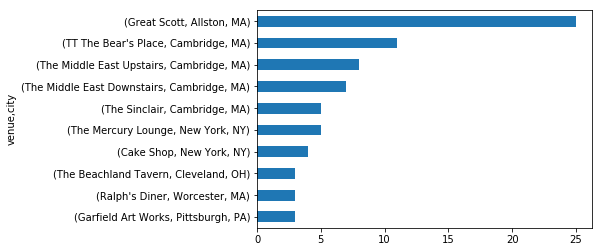

In [34]:
top_venues.sort_values().plot.barh();